In [ ]:
#| default_exp init

In [1]:
#| export
import random, math, torch, numpy as np, matplotlib.pyplot as plt
from tinyai.learner import *
from tinyai.model import *
from tinyai.hooks import *
import fastcore.all as fc
from functools import partial

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

def get_tokens(input_file):
    with open(input_file) as f:
        text = f.read()
    tokens = enc.encode(text)
    return tokens

cwd = os.getcwd()
input_file = f"{cwd}/fast-nanogpt/input.txt"
tokens = get_tokens(input_file)[:10000]
train, valid = tokens[:int(len(tokens)*0.8)], tokens[int(len(tokens)*0.8):]

In [4]:
tds = DataSet(torch.tensor(train))
# vds = DataSet(torch.tensor(valid))
dls = DataLoaders.from_dd([tds, None], batch_size=4)
# dls = DataLoaders.from_dd([tds, vds], batch_size=4)

In [5]:
x, y = next(iter(dls.train))
x[0], y[0]

(tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
          3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
           461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
          1639,   389]),
 tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285,
           502,  2740,    13,   198,   198,  3237,    25,   198,  5248,   461,
            11,  2740,    13,   198,   198,  5962, 22307,    25,   198,  1639,
           389,   477]))

In [6]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [7]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [8]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [9]:
def fit(model, epochs=1, xtra_cbs=None):
    lrn = Learner(model, dls=dls, opt_func=optim.AdamW, cbs=cbs + fc.L(xtra_cbs), lr=3e-4)
    lrn.fit(epochs, valid=False)
    return lrn

In [10]:
# TODO: illustrate why we need normalization for residual

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

# Why init linear weights with std=0.02
According to Xavier initialization, the weights should be initialized with a std of $\sqrt{\frac{1}{n_{in}}}$, where $n_{in}$ is the number of input units.

In the GPT-2 paper, they experimented with different set of hyperparameters (layer numbers, linear layer sizes, etc.) and fond that the std of 0.02 is quite consistent across different settings. 
1 / sqrt(768) = 0.036
1 / sqrt(1280) = 0.028
1 / sqrt(3 * 1600) = 0.014

std = 0.02 is a ok for all these settings.

In [12]:
#|export
def is_residual(m):
    return isinstance(m, ResidualLinear)

In [13]:
rl = ResidualLinear(10, 10)
is_residual(rl)
print(rl)

ResidualLinear(in_features=10, out_features=10, bias=True)


In [19]:
#|export
def init_weights(m):
    std=0.02
    if isinstance(m, nn.Linear):
        if is_residual(m):
            std *= (2 * GPTConfig.n_layer) ** -0.5
        nn.init.normal_(m.weight, mean=0.0, std=std)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=std)

In [45]:
std = 0.02 
std *= (2 * GPTConfig.n_layer) ** -0.5
std

0.004082482904638631

In [27]:
model = get_model().apply(init_weights)

In [46]:
with torch.no_grad():
    heads = model.transformer.h
    for i, head in enumerate(heads, 1):
        print(f"block {i}", head.attn.c_proj.weight.std().item(), head.mlp.c_proj.weight.std().item())

block 1 0.004774801898747683 0.004725766833871603
block 2 0.004663737956434488 0.004678761586546898
block 3 0.0046539390459656715 0.0046400101855397224
block 4 0.004634101875126362 0.004611665848642588
block 5 0.004611934069544077 0.0045923152938485146
block 6 0.00460280803963542 0.004579875152558088
block 7 0.004593615885823965 0.0045714182779192924
block 8 0.004584869369864464 0.004564869683235884
block 9 0.004558835178613663 0.004561019595712423
block 10 0.004568731412291527 0.004559023305773735
block 11 0.00457336287945509 0.004562870133668184
block 12 0.004578678868710995 0.004558037966489792


loss,epoch,train
7.488,0,train


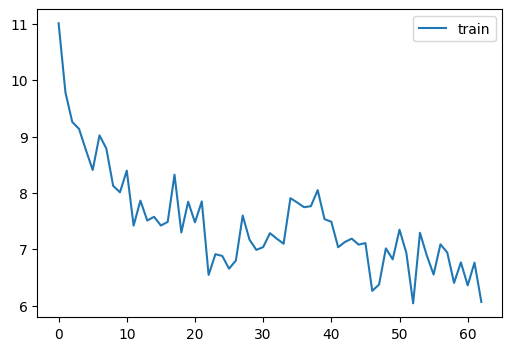

In [34]:
stats = ActivationStats(fc.risinstance(Block))
set_seed(1)
model = get_model()
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB(plot=True)]
lrn = fit(model, xtra_cbs=[stats])

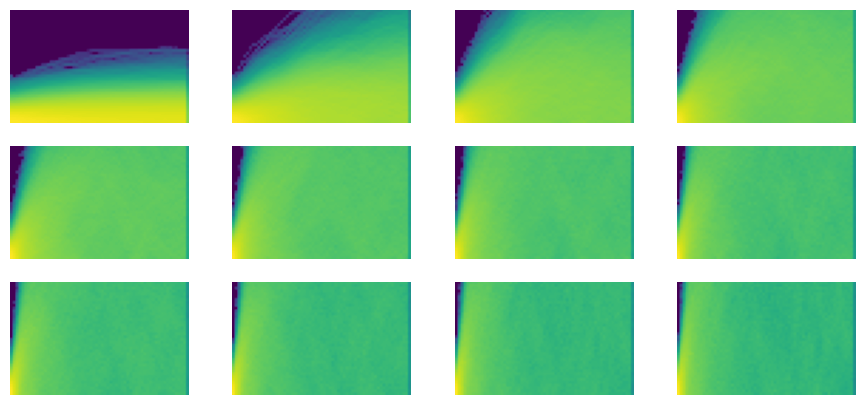

In [36]:
stats.color_dim()

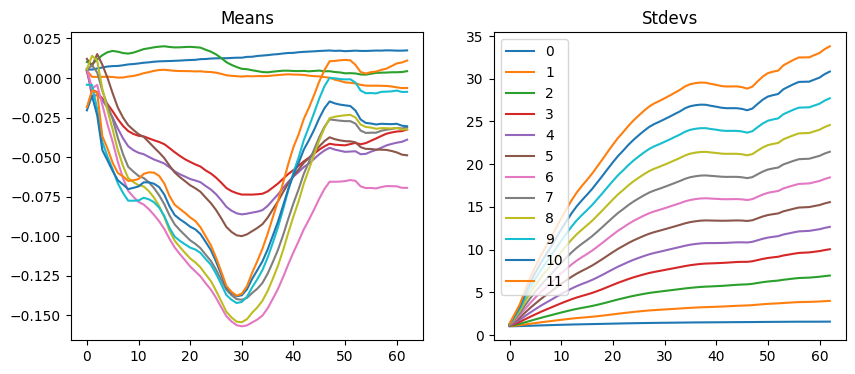

In [37]:
stats.plot_stats()

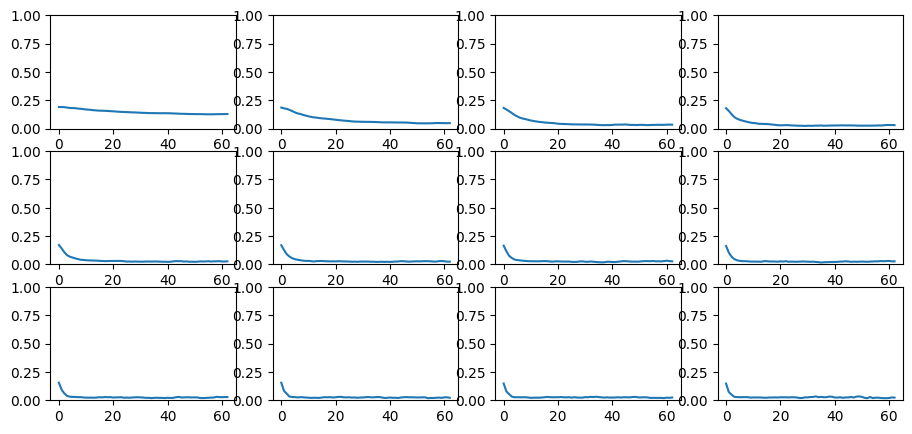

In [38]:
stats.dead_chart()

loss,epoch,train
7.487,0,train


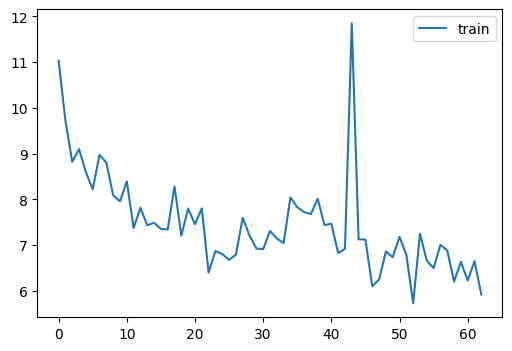

In [41]:
model = get_model().apply(init_weights)
stats = ActivationStats(fc.risinstance(Block))
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB(plot=True)]
lrn = fit(model, xtra_cbs=[stats])

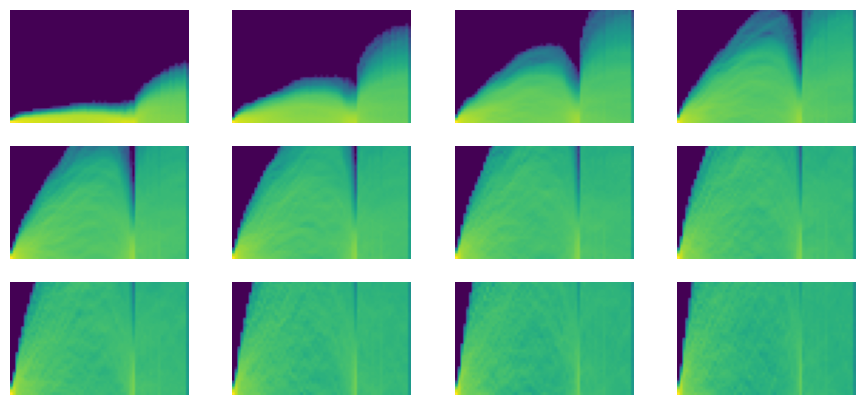

In [42]:
stats.color_dim()

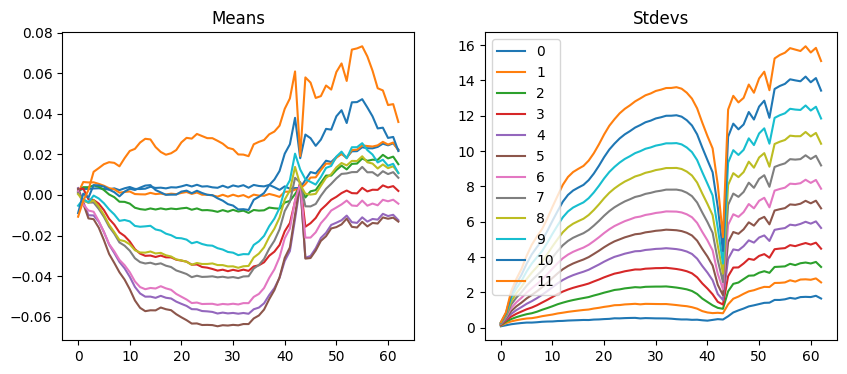

In [43]:
stats.plot_stats()

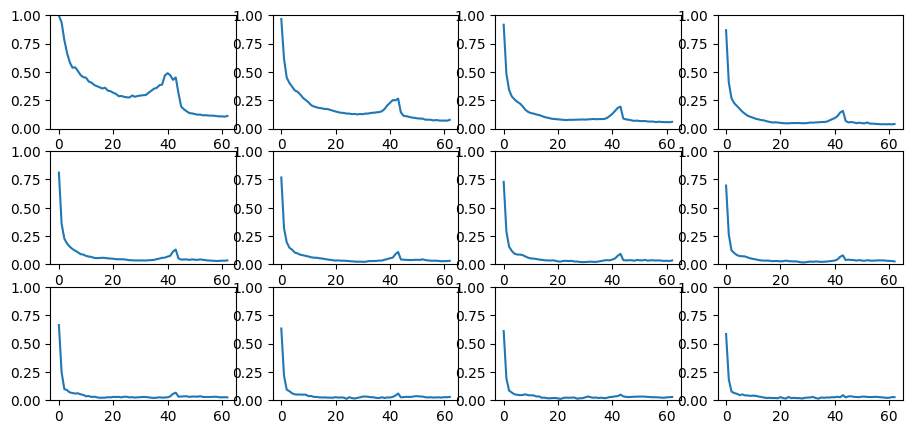

In [44]:
stats.dead_chart()

In [48]:
#|export
class InitCallback(Callback):
    def before_fit(self, learn):
        model = learn.model
        model.apply(init_weights)

loss,epoch,train
7.478,0,train


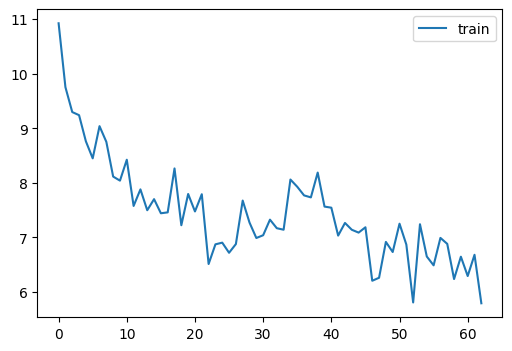

In [49]:
stats = ActivationStats(fc.risinstance(Block))
model = get_model()
lrn = fit(model, xtra_cbs=[InitCallback(), stats])

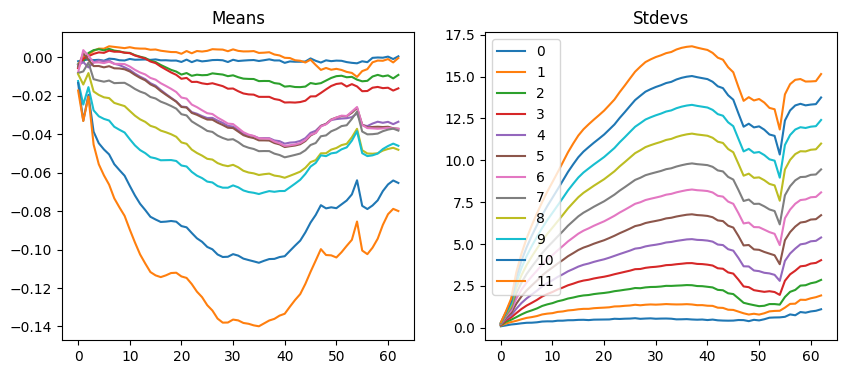

In [50]:
stats.plot_stats()